In [1]:
import pymc as pm
import numpy as np
import arviz as az
from pymc.math import logit, exp
import matplotlib.pyplot as plt
import xarray as xr

np.set_printoptions(suppress=True)
%load_ext lab_black

# Cumulative Example*

Adapted from [Unit 9: cumulative2.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit9/cumulative2.odc).

Original text:

Use of ```cumulative``` as a check for outliers.

How consistent are the data with the model? Check ```cumulative(y[i], y[i])```.

The first y[i] specifies the distribution of y[i]'s, the second is the argument/observation. The output is empirical cdf of y[i]s evaluated at y[i].

Values close to 0 or 1 are potential outliers.

## Notes

From the OpenBUGS manual:

> cumulative(s1, s2): tail area of distribution of s1 up to the value of s2, s1 must be stochastic, s1 and s2 can be the same

This is not too detailed. I had to recreate it in PyMC to understand what exactly is going on. What Brani is doing is calculating the [empirical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function) at each y value. In other words, what is the probability that the posterior samples are less than or equal to each observed y value?

Here's how to do it in PyMC:

In [2]:
# fmt: off
y = np.array(
    [0.0, 1.0, 2.0, -1.0, 0.4, -0.5, 0.7, -1.2, 0.1, -0.4, 
     0.2, -0.5, -1.4, 1.8, 0.2, 0.3, -0.6, 1.1, 5.1, -6.3]
)
# fmt: on

In [3]:
with pm.Model() as model:
    # Priors
    theta = pm.Flat("theta")
    ls = pm.Flat("ls")
    s = pm.math.exp(ls)

    # Likelihood
    pm.Normal("y", mu=theta, sigma=s, observed=y)

    # Sampling
    trace = pm.sample(2000)
    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, ls]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y]


In [4]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.046,0.486,-0.823,0.999,0.006,0.006,6452.0,5366.0,1.0
ls,0.752,0.167,0.450,1.069,0.002,0.001,6795.0,5315.0,1.0


Now we have posterior samples, the equivalent of the stochastic part of the y[i] node in BUGS. Then we can compare them to the original y data:


In [5]:
# transforming data so we can broadcast
y_data = xr.DataArray(y, dims=("y_dim_2",))
y_sampled = trace.posterior_predictive["y"]
y_data = y_data.expand_dims(
    {"chain": y_sampled.chain, "draw": y_sampled.draw}, axis=(0, 1)
)

# "cumulative(y_sampled, y_data)", equivalent of cumulative(y[i], y[i]) in BUGS.
cumulative_sum = (y_sampled <= y_data).sum(dim=["chain", "draw"])
probabilities = cumulative_sum / (y_sampled.chain.size * y_sampled.draw.size)

print(probabilities)

# add[i] = pow(logit(cuy[i]),2)
add_probabilities = np.log(probabilities / (1 - probabilities)) ** 2
print(add_probabilities)
print(add_probabilities.sum())

<xarray.DataArray (y_dim_2: 20)>
array([0.49925 , 0.665625, 0.81325 , 0.31125 , 0.559   , 0.400125,
       0.617125, 0.275875, 0.513375, 0.42    , 0.523   , 0.40575 ,
       0.257625, 0.787875, 0.5415  , 0.544   , 0.373625, 0.68025 ,
       0.986125, 0.00275 ])
Coordinates:
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
<xarray.DataArray (y_dim_2: 20)>
array([ 0.000009  ,  0.47398176,  2.16462877,  0.63088376,  0.05621859,
        0.16397989,  0.22787546,  0.9312562 ,  0.00286362,  0.10418266,
        0.00847596,  0.14559025,  1.12010359,  1.72177364,  0.02768323,
        0.03113687,  0.26697539,  0.56990562, 18.17909046, 34.73217039])
Coordinates:
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
<xarray.DataArray ()>
array(61.5587851)


This should give equivalent results. They aren't identical but they detect the same outliers.

## Other ways to check model fit

I know I say this a lot but I would definitely like to expand on this more in the future!

### Plot posterior predictive distribution vs. observed values

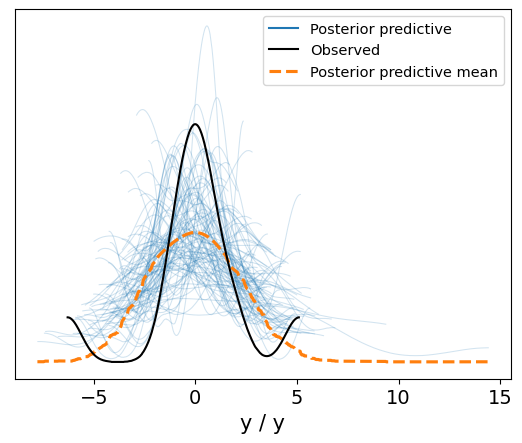

In [6]:
az.plot_ppc(trace, num_pp_samples=100)
plt.show()

Doesn't look like our posterior does a good job of fitting the observed data because of the outliers.

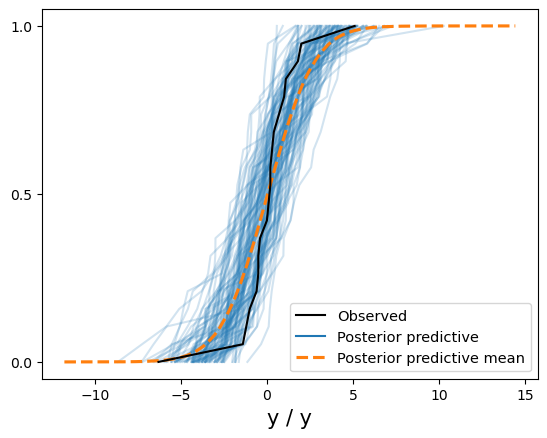

In [7]:
az.plot_ppc(trace, kind="cumulative", num_pp_samples=100)
plt.show()

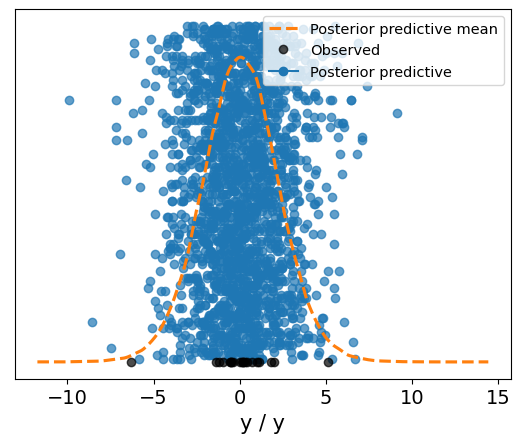

In [8]:
az.plot_ppc(trace, kind="scatter", num_pp_samples=100)
plt.show()

The below code is not working for me since PyMC 5. I'm not sure what happened. It should look like the example below, from their [documentation](https://python.arviz.org/en/v0.15.1/api/generated/arviz.plot_lm.html).

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

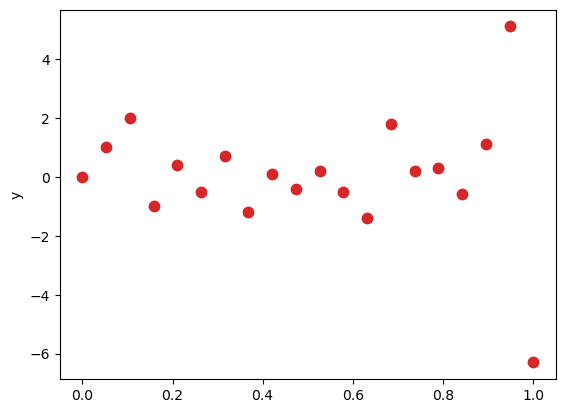

In [9]:
# broken?!
x = xr.DataArray(np.linspace(0, 1, 20))
az.plot_lm(idata=trace, y="y", x=x)
plt.show()

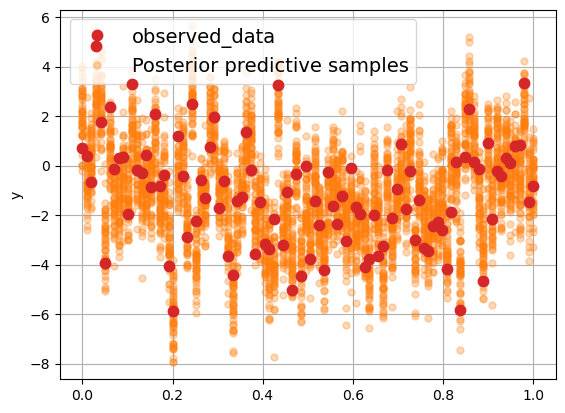

In [13]:
# docs example still working though
# from https://python.arviz.org/en/stable/api/generated/arviz.plot_lm.html

idata = az.load_arviz_data("regression1d")
x = xr.DataArray(np.linspace(0, 1, 100))
idata.posterior["y_model"] = idata.posterior["intercept"] + idata.posterior["slope"] * x
az.plot_lm(idata=idata, y="y", x=x)
plt.show()

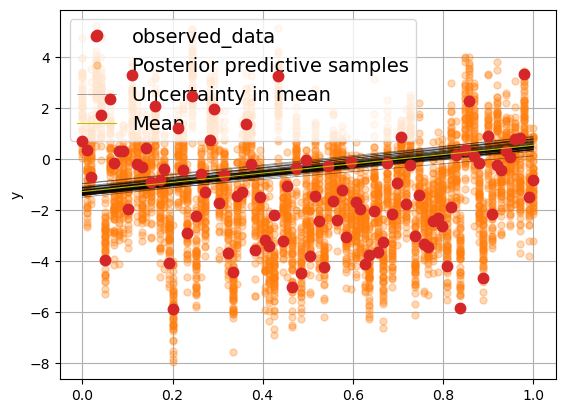

In [14]:
az.plot_lm(idata=idata, y="y", x=x, y_model="y_model")
plt.show()

In [15]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Mon Apr 03 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.9.0

pytensor: 2.10.1

xarray    : 2023.1.0
numpy     : 1.24.2
matplotlib: 3.6.3
pymc      : 5.1.2
arviz     : 0.15.1

